# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Дерево решений


**Общая информация**

**Срок сдачи:** до 27 марта 2018, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 27 марта, -4 балла после 06:00 3 апреля, -6 баллов после 06:00 10 апреля

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw2.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Разберитесь в коде MyDecisionTreeClassifier, который уже частично реализован. В комментариях, где написано "Что делает этот блок кода?", ответьте на этот вопрос. Допишите код там, где написано "Ваш код". Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn. Точность проверяется на wine и Speed Dating Data.

###### Задание 2 (2 балла)
Добиться скорости работы на fit сравнимой со sklearn wine и Speed Dating Data. 
Для этого используем numpy. 

###### Задание 3 (2 балла)
Продемонстрируйте умение работать с Pipeline на данных Speed Dating Data и DecisionTreeClassifier. Нужно в pipeline произвести все необходимые преобразования данных и в конце обучить модель. Задание реализуйте под пунктом Задание 3 (уже написано ниже)

###### Задание 4 (2 балла)
Добавьте функционал, который определяет значения feature importance. Выведите 10 главных фичей под пунктом Задание 4 (уже написано ниже) для MyDecisionTreeClassifier и DecisionTreeClassifier так, чтобы сразу были видны выводы и по MyDecisionTreeClassifier, и по DecisionTreeClassifier. Используем данные Speed Dating Data.

###### Задание 5 (2 балла)
С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса (Выберете 2-3 параметра). Используем данные Speed Dating Data. Задание реализуйте под пунктом Задание 5 (уже написано ниже)


**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [765]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# %matplotlib inline
# %load_ext pycodestyle_magic

In [871]:
#%%pycodestyle


class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, sufficient_share=1.0, criterion='gini', max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.feature_importances_ = None
        if criterion == 'gini':
            self.G_function = self.__gini
            self.single_G_function = self.__single_gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
            self.single_G_function = self.__single_entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
            self.single_G_function = self.__single_misclass
        else:
            print('invalid criterion name')
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise

    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype(np.float)
        r_s = r_s.astype(np.float)
        return l_s * (1 - np.sum((l_c / l_s) ** 2, axis=1)[:, np.newaxis]) + r_s * (1 - np.sum((r_c / r_s) ** 2, axis=1)[:, np.newaxis])
    
    def __single_gini(self, y):
        counts = np.unique(y, return_counts=True)[1]
        return y.size * (1 - np.sum((counts / y.size) ** 2))
    
    def __entropy(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype(np.float)
        r_s = r_s.astype(np.float)
        return -l_s * np.sum(l_c / l_s * np.log2(l_c / l_s), axis=1)[:, np.newaxis] - r_s * np.sum(r_c / r_s * np.log2(r_c / r_s), axis=1)[:, np.newaxis]

    def __single_entropy(self, y):
        counts = np.unique(y, return_counts=True)[1]
        return -y.size * np.sum((counts / y.size) * np.log2(counts / y.size))
    
    def __misclass(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype(np.float)
        r_s = r_s.astype(np.float)
        return l_s * (1 - np.max(l_c / l_s, axis=1)[:, np.newaxis]) + r_s * (1 - np.max(r_c / r_s, axis=1)[:, np.newaxis])
    
    def __single_misclass(self, y):
        counts = np.unique(y, return_counts=True)[1]
        return y.size * (1 - np.max(counts / y.size))
    
    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(sqrt(n_feature))]
        
    def __get_feature_ids_log2(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(log2(n_feature))]

    def __get_feature_ids_N(self, n_feature):
        return range(n_feature)
    
    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        # Что делает этот блок кода?
        sorted_x, sorted_y = self.__sort_samples(x, y) # Сортируем строки данных по признаку x
        #class_number = np.unique(y).shape[0] # Запоминаем кол-во уникальных значений целевой переменной
        class_number = self.num_class
        
        sorted_x, sorted_y = self.__sort_samples(x, y)
        class_number = self.num_class
        
        cut_size = np.int(self.min_samples_split / 2 - 1)        
        if cut_size == 0:
            splitted_sorted_y = sorted_y
        else:
            splitted_sorted_y = sorted_y[cut_size:-cut_size] # Вырезаем часть столбца целевой переменной
        r_border_ids = np.where(splitted_sorted_y[:-1] != splitted_sorted_y[1:])[0] + (cut_size + 1) # запоминаем индексы несовпадений
        # запоминаем в пределах этого выреза индексы тех значений целевой переменной, которые отличаются от предыдущего значения 
        # целевой переменной     
        
        # в качестве порогов для "нарезания" количественного признака, 
        # дерево должно"смотреть" на те значения, при которых целевой класс меняет свое значение.  
        if len(r_border_ids) == 0:
            return np.inf, None
        
        # Что делает этот блок кода?
        eq_el_count = r_border_ids - np.append(np.array([cut_size]), r_border_ids[:-1])
        one_hot_code = np.zeros((r_border_ids.shape[0], class_number))
        one_hot_code[np.arange(r_border_ids.shape[0]), sorted_y[r_border_ids - 1]] = 1
        class_increments = one_hot_code * eq_el_count.reshape(-1, 1)
        class_increments[0] = class_increments[0] + np.bincount(sorted_y[:cut_size], minlength=class_number)
        
        # Что делает этот блок кода?
        l_class_count = np.cumsum(class_increments, axis=0)     # формируется матрица, размера: 
        # число значений целевой переменной на число разбиений, у которой каждая строка - число сэмплов с левой стороны разбиения
        # c таким-то значением целевой переменной (например если при первом разбиении слева оказались 3 единицы и два нуля, то 
        # первая строка этой матрицы - [2 3] и т.д.)
        r_class_count = np.bincount(sorted_y, minlength=class_number) - l_class_count
        # то же самое, но справа от разбиения
        l_sizes = r_border_ids.reshape(l_class_count.shape[0], 1)
        # число элементов слева от разбиения в сумме
        r_sizes = sorted_y.shape[0] - l_sizes
        # число элементов справа от разбиения в сумме
        

        # Что делает этот блок кода?
        gs = self.G_function(l_class_count, l_sizes, r_class_count, r_sizes) 
        # Находим impurity в соответствии с выбранной функцией оценки приращения информации (энтропия, gini_index и т.д.)
        idx = np.argmin(gs)
        # Запоминаем индекс лучшего разбиения
    
        # Что делает этот блок кода?
        left_el_id = l_sizes[idx][0]
        return gs[idx], (sorted_x[left_el_id-1] + sorted_x[left_el_id]) / 2.0 
        
        # Первое возвращаем значение - индекс лучшего разбиения
        # Второе возвращаемое значение - все границы, полученные как среднее между теми двумя признаками, при проходе через которые
        # целевая переменная меняет свое значение

    def __fit_node(self, x, y, node_id, depth, pred_f=-1): 
        if depth == self.max_depth or x.shape[0] < self.min_samples_split or np.unique(y).shape[0] == 1:
            self.tree[node_id] = (self.LEAF_TYPE, np.bincount(y).argmax())
            return             
        
        features_threshold = np.zeros(x.shape[1])
        features_impurity = np.zeros(x.shape[1])
        
        for feature_id in self.get_feature_ids(x.shape[1]):
            features_impurity[feature_id], features_threshold[feature_id] = self.__find_threshold(x[:,feature_id],y)
            if feature_id == pred_f:
                features_threshold[feature_id] = np.inf
        
        feature_id = np.argmin(features_impurity)
        
        x_l, x_r, y_l, y_r = self.__div_samples(x, y, feature_id, features_threshold[feature_id])
        
        if y_l.shape[0] == 0 or y_r.shape[0] == 0:
            self.__create_leaf(y,node_id)
            return

        self.tree[node_id] = (self.NON_LEAF_TYPE,feature_id,features_threshold[feature_id])
        self.feature_importances_[feature_id] += self.single_G_function(y) - self.single_G_function(y_l) - self.single_G_function(y_r)
        self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1, feature_id)
        self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1, feature_id)
        
    def __create_leaf(self, y, node_id):  
        counts = np.bincount(y, minlength=self.num_class)
        probs = counts / np.sum(counts).astype('float')
        self.tree[node_id] = (self.LEAF_TYPE, np.argmax(counts), probs)        
    
    def fit(self, x, y):
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0) 
        self.feature_importances_ /= y.size

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]
        
    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    def score(self, x,y_test):
        return f1_score(y_pred=my_clf.predict(x), y_true=y_test, average='macro')
    def tree(self):
        tr = np.copy(self.tree)
        return tr

In [872]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [873]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

## Проверка скорости работы на wine

In [874]:
%time clf.fit(X_train, y_train)

Wall time: 2 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [875]:
%time my_clf.fit(X_train, y_train)

Wall time: 47 ms


## Проверка качества работы на wine

In [876]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.77777777777777768

In [877]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.77777777777777768

## Подготовка данных Speed Dating Data 

Field Code 1.0
['Law' 'law' 'LAW' 'Law and Social Work'
 'Law and English Literature (J.D./Ph.D.)' 'Intellectual Property Law'
 'Law/Business']
Field Code 2.0
['Economics' 'Mathematics' 'Statistics' 'math' 'Mathematics, PhD' 'Stats'
 'math of finance' 'Math']
Field Code 3.0
['Psychology' 'Speech Language Pathology' 'Speech Languahe Pathology'
 'Educational Psychology' 'Organizational Psychology' 'psychology'
 'Communications' 'Sociology' 'psychology and english' 'theory'
 'Health policy' 'Clinical Psychology' 'Sociology and Education'
 'sociology' 'Anthropology/Education' 'speech pathology' 'Speech Pathology'
 'Anthropology' 'School Psychology' 'anthropology' 'Counseling Psychology'
 'African-American Studies/History']
Field Code 4.0
['Medicine' 'Art History/medicine'
 'Sociomedical Sciences- School of Public Health' 'Epidemiology'
 'GS Postbacc PreMed' 'medicine']
Field Code 5.0
['Operations Research' 'Mechanical Engineering' 'Engineering'
 'Electrical Engineering' 'Operations Researc

,match,int_corr,samerace,age,field_cd,mn_sat,tuition,race,imprace,imprelig,...,sinc2_1_f,intel2_1_f,fun2_1_f,amb2_1_f,shar2_1_f,attr3_1_f,sinc3_1_f,fun3_1_f,intel3_1_f,amb3_1_f
100,0,0.14,0,27.0,8.0,-999.0,-999.0,2.0,7.0,3.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
110,0,0.54,0,22.0,1.0,-999.0,-999.0,2.0,1.0,1.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
120,1,0.16,1,22.0,1.0,-999.0,-999.0,4.0,3.0,5.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
130,1,0.61,0,23.0,1.0,-999.0,-999.0,2.0,1.0,1.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
140,1,0.21,0,24.0,1.0,-999.0,-999.0,3.0,3.0,1.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0


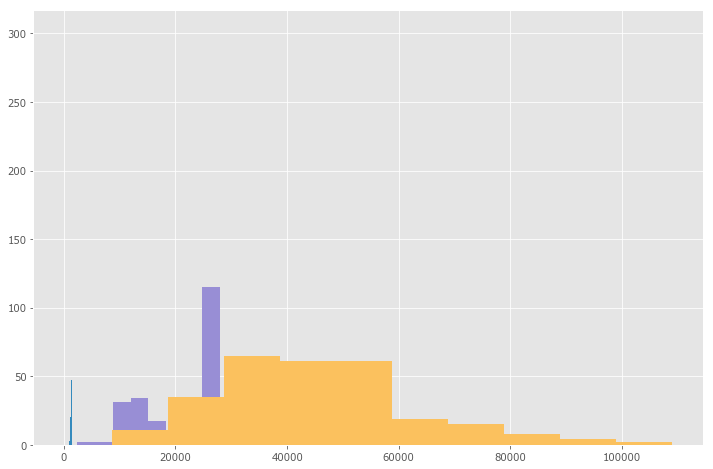

In [878]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

df = pd.read_csv('speed-dating-experiment/Speed Dating Data.csv')

df.shape

df = df.iloc[:, :97]
df.iid.nunique()
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)

df.drop_duplicates(subset=['iid']).gender.value_counts()
df.drop_duplicates(subset=['iid']).condtn.value_counts()
df = df.drop(['condtn'], axis=1)

df.wave.unique()

df = df.drop(['round'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)


df = df.drop(['order'], axis=1)
df = df.drop(['partner'], axis=1)
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

df.drop_duplicates(subset=['iid']).age.hist(bins=20)

df.drop_duplicates('iid').age.isnull().sum()

df = df.dropna(subset=['age'])

for i, group in df.groupby('field_cd'):
    print('=' * 10)
    print('Field Code {}'.format(i))
    print(group.field.unique())

df.field_cd.isnull().sum()
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df = df.drop(['field'], axis=1)
df.undergra.value_counts().head()
df = df.drop(['undergra'], axis=1)

df.mn_sat.value_counts().head()

df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.drop_duplicates('iid').mn_sat.hist()
df.drop_duplicates('iid').mn_sat.isnull().sum()

df.loc[:, 'mn_sat'] = df.mn_sat.fillna(-999)


df.tuition.value_counts().head()
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.drop_duplicates('iid').tuition.hist()
df.drop_duplicates('iid').tuition.isnull().sum()
df.loc[:, 'tuition'] = df.tuition.fillna(-999)

df.drop_duplicates('iid').race.value_counts()
df.drop_duplicates('iid').age.isnull().sum()
df.drop_duplicates('iid').race.hist()
df.drop_duplicates('iid').imprace.isnull().sum()
df.drop_duplicates('iid').imprelig.isnull().sum()


df = df.dropna(subset=['imprelig', 'imprace'])
df = df.drop(['from', 'zipcode'], axis=1)

df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.drop_duplicates('iid').loc[:, 'income'].hist()
df.drop_duplicates('iid').loc[:, 'income'].isnull().sum()
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)

df.loc[:, 'date'].isnull().sum()

df = df.dropna(subset=['date'])
df.career_c.isnull().sum()

df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df = df.drop(['career'], axis=1)

df.loc[:, ['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
      ].isnull().sum()

df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

df.drop_duplicates('iid').exphappy.isnull().sum()
df.drop_duplicates('iid').expnum.isnull().sum()

df = df.drop(['expnum'], axis=1)


feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]

df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]

df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

df = df.drop(['temp_totalsum'], axis=1)

for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

df = df.drop(['wave'], axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'

from sklearn.model_selection import train_test_split

df_pair = df_male.join(df_female.set_index('iid_f'), on = 'pid', how = 'inner')
df_pair = df_pair.drop(['iid', 'pid'], axis = 1)
df_pair.head()



In [879]:
from sklearn.model_selection import train_test_split

X = df_pair.iloc[:, 1:].values
y = df_pair.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [880]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold

In [881]:
my_clf = MyDecisionTreeClassifier()
clf = DecisionTreeClassifier()

## Проверка скорости работы на Speed Dating Data 

In [882]:
%time clf.fit(X_train, y_train)

Wall time: 126 ms


In [883]:
%time my_clf.fit(X_train, y_train)

Wall time: 1.64 s


## Проверка качества работы на Speed Dating Data

In [884]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.49853333171046388

In [885]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.53622019458587489

## Задание 3

In [724]:
pipeline = Pipeline([
    ('clf', DecisionTreeClassifier()),
])

pipeline.fit(X_train, y_train)
f1_score(y_pred=pipeline.predict(X_test), y_true=y_test, average='macro')

0.63909774436090228

## Задание 4

In [886]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

my_clf = MyDecisionTreeClassifier()
my_clf.fit(X_train, y_train)

features_names = df_pair.columns[1:]

print('DecisionTreeClassifier')
print(pd.Series(index=features_names, data=clf.feature_importances_).sort_values(ascending=False).head(10))
print('MyDecisionTreeClassifier')
print(pd.Series(index=features_names, data=my_clf.feature_importances_).sort_values(ascending=False).head(10))

print(f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro'))
print(f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro'))

DecisionTreeClassifier
int_corr      0.075959
income_f      0.038975
age_f         0.029798
amb1_1_f      0.028036
attr2_1_f     0.027837
field_cd_f    0.027197
intel2_1_f    0.026136
shar1_1       0.024629
date_f        0.024018
go_out_f      0.022423
dtype: float64
MyDecisionTreeClassifier
exphappy      0.021395
int_corr      0.017227
income_f      0.011948
age_f         0.008614
imprelig      0.008058
shar1_1       0.007780
samerace      0.006946
sinc1_1_f     0.006946
field_cd_f    0.006669
imprace_f     0.005557
dtype: float64
0.516031457955
0.536220194586


## Задание 5

In [887]:
# Speed Dating Data
param_dist = {"max_depth": [1, 2, 3, 4, 5, 6, 7, 8, None], "min_samples_split": range(2, 11), "criterion": ["gini", "entropy"]}

gscv = RandomizedSearchCV(RandomForestClassifier(n_estimators=10), param_dist, n_iter=10)
gscv.fit(X_train, y_train)
print(gscv.best_params_)

{'min_samples_split': 5, 'criterion': 'entropy', 'max_depth': 8}
